<div >
    <img src = "../banner/banner_ML_UNLP_1900_200.png" />
</div>

<a href="https://colab.research.google.com/github/ignaciomsarmiento/ML_UNLP_Lectures/blob/main/Week05/Notebook_SS05_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificando digitos con Redes Neuronales usando Keras 

Uno de los conjuntos de datos ampliamente utilizados para la clasificación de imágenes es el conjunto de datos MNIST (LeCun et al., 1998) de dígitos escritos a mano. En el momento de su lanzamiento en la década de 1990, planteó un desafío formidable para la mayoría de los algoritmos de aprendizaje automático, que constaba de 60.000 imágenes de  resolución28x28  de píxeles (más un conjunto de datos de prueba de 10,000 imágenes).

 Lograr una alta precisión en el reconocimiento de dígitos fue un componente clave en la automatización de la clasificación de cartas para el servicio postal de EEUU.

Durante más de una década, MNIST sirvió como punto de referencia para comparar algoritmos de aprendizaje automático.

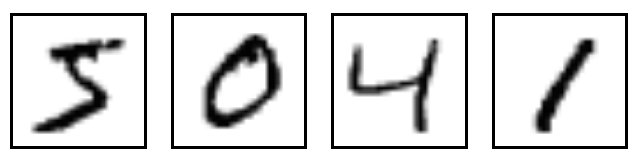


## Cargando los datos

## Preparando el conjunto de datos MNIST

La mayoría de las bibliotecas de aprendizaje profundo proporcionan API para cargar conjuntos de datos famosos como MNIST (por ejemplo, `torchvision.datasets.MNIST` en pytorch). Las API son útiles, pero ocultan el paso importante para preparar datos de entrenamiento para un marco de aprendizaje profundo; Al pasar de un conjunto de datos de ejemplo a datos reales, debemos convertir los datos de entrenamiento de nuestro interés en la estructura de datos que sea aceptable para un marco de aprendizaje profundo.

El siguiente código descarga la distribución original del conjunto de datos MNIST en la Web, convierte el conjunto de datos en matrices `numpy' y guarda las matrices como el archivo "mnist.npz" con nombres de palabras clave.

In [1]:
import gzip
import sys
import struct
import urllib.request
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11", 
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

if __name__ == '__main__':
    np.savez_compressed(
        'mnist',
        train_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')),
        train_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')),
        test_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')),
        test_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'))
    )
     

El archivo contiene cuatro matrices numerosas (un tensor y una matriz para cada división de conjuntos de entrenamiento y prueba) con las palabras clave:

+ `train_x`: $60000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `train_y`: $60000 \text{ (labels)}$
+ `test_x`: $10000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `test_y`: $10000 \text{ (labels)}$


In [2]:

data = np.load('mnist.npz')

print(data['train_x'].shape, data['train_x'].dtype)
print(data['train_y'].shape, data['train_y'].dtype)
print(data['test_x'].shape, data['test_x'].dtype)
print(data['test_y'].shape, data['test_y'].dtype)

(60000, 28, 28) float32
(60000,) uint8
(10000, 28, 28) float32
(10000,) uint8


In [4]:
X_train=data['train_x']
X_test=data['test_x']
y_train=data['train_y']
y_test=data['test_y']

## Visualizando los datos

3


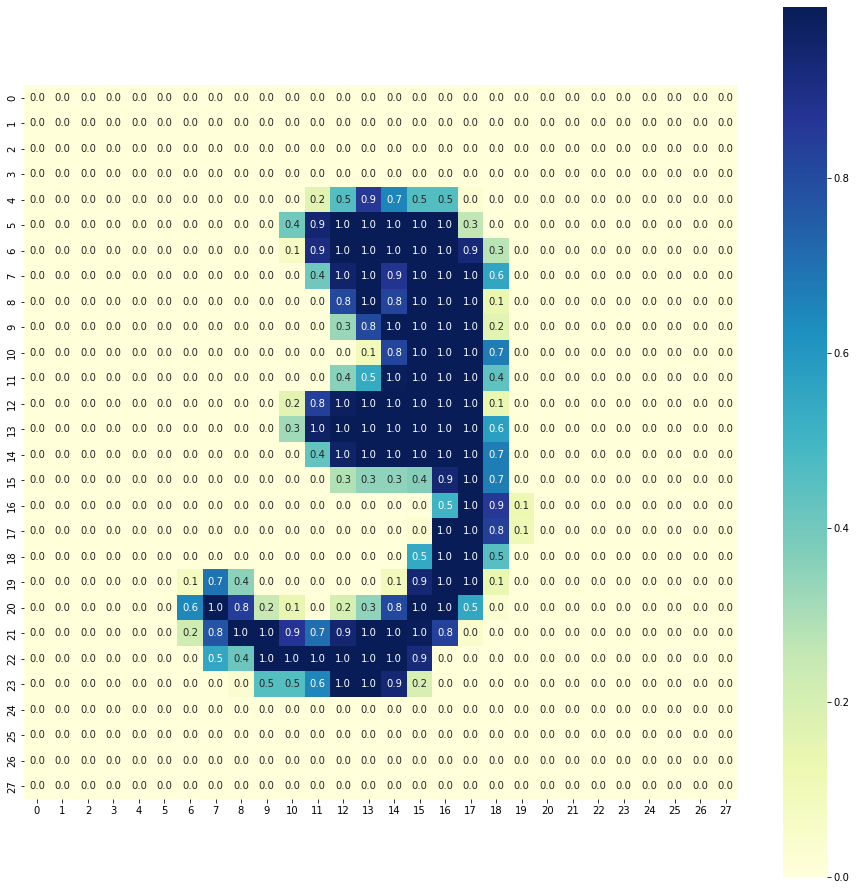

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Index number of an instance (change this to view another instance).
i = 10

data = np.load('mnist.npz')
image = data['train_x'][i]
label = data['train_y'][i]

print(label)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

## Armando la primer red

### Configurar las capas 

La arquitectura de una red neuronal se construye a partir de capas. Las capas son bloques fundamentales que procesan la entrada y producen la salida. Cada capa se configura con un conjunto de parámetros que definen cómo se transforma la entrada en la salida y los flujos a través de ellas.

Una red neuronal típicamente se compone de tres tipos de capas: capas de entrada, capas ocultas y capas de salida. Cada capa se compone de un conjunto de neuronas que procesan la información de entrada y producen una salida.

* Capas de entrada: son la primera capa de la red y se encargan de recibir los datos de entrada y procesarlos para pasarlos a la siguiente capa. 
* Capas ocultas: son capas intermedias entre la capa de entrada y la capa de salida. En estas capas, la información de entrada se procesa y se extraen características relevantes de los datos. Estas capas son importantes porque determinan la capacidad de la red para aprender patrones complejos y representaciones abstractas.
* Capas de salida: son la última capa de la red y se encargan de producir la salida final. En una red neuronal de clasificación, como la que estamos construyendo, la capa de salida tendría un conjunto de neuronas que representan las diferentes clases posibles y producirían una salida para indicar a qué clase pertenece el dato de entrada.



Existen varios tipos de capas ocultas, veremos a continuación algunas de estas para entrenar el modelo. Al configurar las capas, se debe especificar la cantidad y tipo de capas que se utilizarán, así como los parámetros específicos de cada capa. 

In [8]:
import tensorflow as tf
#import tensorflow_datasets as tfds

In [11]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])


2023-12-01 18:36:38.808444: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Dense

En una capa `Dense`, cada neurona está conectada a todas las neuronas de la capa anterior. Los `units`que se especifican en los parámetros, se refieren a la cantidad de neuronas que se deben incluir en una capa determinada de la red neuronal. Es decir, los units son el número de nodos de la capa. Por último, el parámetro `activation`  especifica la función de activación que se va a usar en esa capa de la red.



### Aside: The softmax function

Multinomial logistic regrssion

\begin{align}
Pr(y=j | X) = \frac{e^{h_i}}{\sum_{j=1}^K e^{h_j}}
\end{align}




In [9]:
import numpy as np

h = np.array([1.3, 7.3, 2.2, 0.7, 1.1, 2.5, 3.1, 4.5, 1.3, 1.8])

softmax_result = np.exp(h) / np.sum(np.exp(h))

softmax_result

array([0.00224817, 0.90697501, 0.0055296 , 0.00123382, 0.00184064,
       0.00746417, 0.01360061, 0.05515321, 0.00224817, 0.0037066 ])

In [ ]:
model

In [ ]:
np.log(0.9)

## Entrenando la primera red

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)



### Compilar el modelo

Antes de que el modelo esté listo para el entrenamiento, necesita algunos ajustes más. Éstos se añaden durante el paso de compilación del modelo:

* Función de pérdida: mide la precisión del modelo durante el entrenamiento. Queremos minimizar esta función para "dirigir" el modelo en la dirección correcta.

* Optimizador: Así es como se actualiza el modelo basándose en los datos que ve y en su función de pérdida.

* Métricas: se utiliza para evaluar el rendimiento en cada paso del proceso de entrenamiento. Esto permite monitorizar cómo se está desempeñando el modelo a lo largo del tiempo y ajustar la arquitectura de la red si es necesario.

Usaremos respectivamente los siguientes parámetros: 

* La función `SparseCategoricalCrossentropy` que compara la distribución de probabilidad predicha por el modelo con la distribución de probabilidad real de las etiquetas de clase. Calcula la diferencia entre estas dos distribuciones y devuelve un valor de pérdida. 

* `Adam`  un algoritmo de optimización de gradiente descendente estocástico popular utilizado en el aprendizaje automático y la optimización de redes neuronales. Para saber más de este pueden ir [acá](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/).

* Usamos `SparseCategoricalAccuracy` como métrica de desempeño. 



### Entrenar el modelo 



In [13]:

# Train model.
history =model.fit(X_train, y_train, epochs = 8, batch_size = 128, validation_split = 0.2,verbose = 0)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

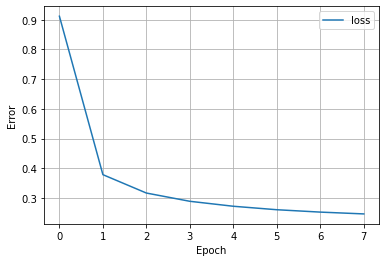

In [14]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss') 
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)




In [15]:
model.evaluate(
    X_test, y_test, verbose=1)


313/313 [==============================] - 0s 506us/step - loss: 0.2487 - sparse_categorical_accuracy: 0.9278


[0.24867455661296844, 0.9277999997138977]

## Arquitectura de redes y capas múltiples

In [16]:
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               200960    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [19]:
256*784+256

200960

In [20]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


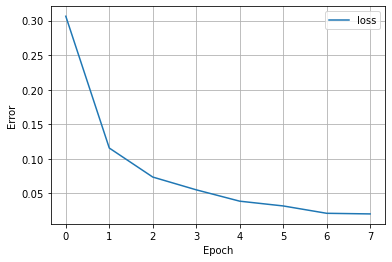

In [21]:

# Train model.
history =model2.fit(X_train, y_train, epochs = 8, batch_size = 128, validation_split = 0.2,verbose = 0)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plot_loss(history)

In [24]:
hist

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,epoch
0,0.306365,0.912083,0.147339,0.958750,0
1,0.115533,0.965729,0.107942,0.966333,1
2,0.073510,0.978000,0.101566,0.968333,2
3,0.055019,0.983667,0.082354,0.973667,3
4,0.038573,0.988417,0.081376,0.975417,4
5,0.031679,0.989792,0.082791,0.976417,5
6,0.021029,0.993625,0.088032,0.976833,6
7,0.020132,0.993375,0.092248,0.974333,7


In [22]:
model2.evaluate(
    X_test, y_test, verbose=1)


313/313 [==============================] - 0s 1ms/step - loss: 0.0916 - sparse_categorical_accuracy: 0.9748


[0.0915767028927803, 0.9747999906539917]

## Dropout Learning
Esta es una forma de regularización relativamente nueva y eficiente. Inspirado en los random forest, la idea es eliminar aleatoriamente una fracción $\phi$ de las unidades en una capa al ajustar el modelo. 

Las unidades sobrevivientes sustituyen a las que faltan y sus pesos aumentan en un factor de 1/(1 − φ) para compensar. Esto evita que los nodos se especialicen demasiado, llevando a sobreajuste.

Puede ser visto como una forma de regularización. 

En la práctica, el "dropout" se logra configurando aleatoriamente los nodos  "abandonados" a cero, mientras se mantiene intacta la arquitectura.

In [25]:
256*.6

153.6

In [35]:
# Define the sequential model
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(256, activation='cosine'),
  tf.keras.layers.Dropout(rate=0.4),
  tf.keras.layers.Dense(128, activation='cosine'),
  tf.keras.layers.Dropout(rate=0.3),
  tf.keras.layers.Dense(10, activation='softmax')
])

model3.summary()


ValueError: Unknown activation function: cosine. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [32]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)



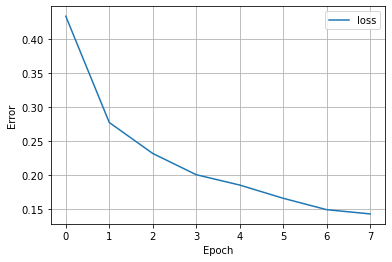

In [33]:

# Train model.
history =model3.fit(X_train, y_train, epochs = 8, batch_size = 128, validation_split = 0.2,verbose = 0)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plot_loss(history)

In [34]:
model3.evaluate(
    X_test, y_test, verbose=1)


313/313 [==============================] - 0s 1ms/step - loss: 0.1051 - sparse_categorical_accuracy: 0.9684


[0.10508091002702713, 0.9684000015258789]